#### import libraries 

In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow import keras
from keras import layers 
import imageio.v2 as imageio
import os 
import pandas as pd 

#### loading data

In [2]:
image_dir = os.listdir("data/CameraRGB/")
segment_dir = os.listdir("data/CameraSeg/")

images_path = ["data/CameraRGB/"+i for i in image_dir]
masks_path = ["data/CameraSeg/"+i for i in segment_dir]

In [3]:
len(images_path)

1000

#### visualizing data

(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)


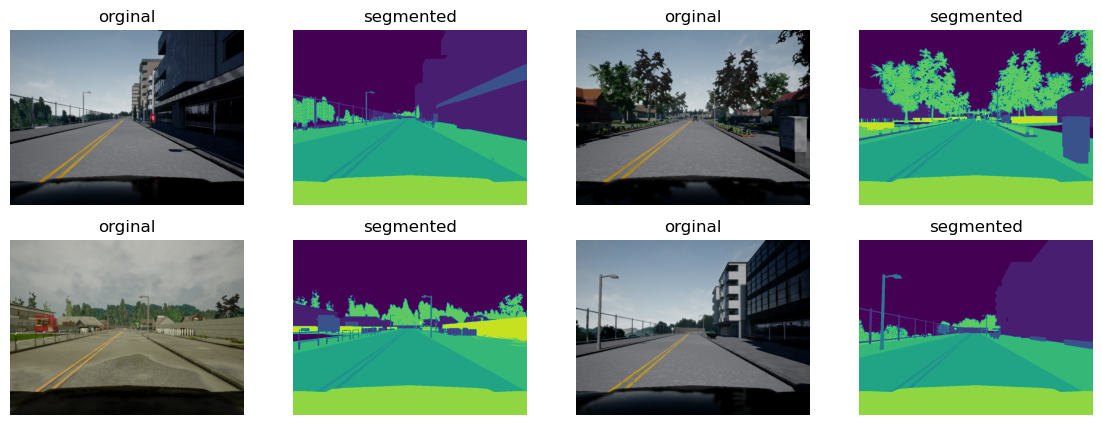

In [4]:
plt.figure(figsize=(14,5))
for i in range(1,8,2):
    n = np.random.randint(0,999)
    
    plt.subplot(2,4,i)
    plt.imshow(imageio.imread(images_path[n]))
    plt.axis("off")
    plt.title("orginal")
    
    plt.subplot(2,4,i+1)
    plt.imshow(imageio.imread(masks_path[n])[:,:,0])
    plt.axis("off")
    plt.title("segmented")
    print(imageio.imread(masks_path[n]).shape)

#### preprocessing image 

In [19]:
images_path_tensor = tf.constant(images_path)
masks_path_tensor = tf.constant(masks_path)

dataset_path = tf.data.Dataset.from_tensor_slices((images_path_tensor,masks_path_tensor))

#### creating dataset object from images

In [22]:
def preprocess_path(img_path , seg_path):
    """
    this create proper image from their path 

    arguments:
    img_path -- path of orginal image 
    seg_path -- path of segmented path 

    returns : 
    img -- image of img_path
    seg -- image of seg_path 

    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img , tf.float32)
    img = tf.image.resize(img , (96,128),method="nearest")
    img = img / 255.

    seg = tf.io.read_file(seg_path)
    seg = tf.image.decode_png(seg,channels=3)
    seg = tf.math.reduce_max(seg , axis = -1 , keepdims=True) 
    seg = tf.image.resize(seg , (96,128),method="nearest")
    

    return img , seg 

In [24]:
dataset = dataset_path.map(preprocess_path)

### U_net 

In [7]:
def conv_block(input=None,filters=32,dropout=0,max_pool=True):
    """
    this implement a block of convolutions for downsampling 

    arguments:
    input -- output of a previous layer
    filters -- number of filters we shoud use in every  layers of block 
    dropout -- value for dropout 
    max_pool -- boolean for useing max pool or not 

    returns:
    next_layer -- output for next convolution block 
    skip_conection -- output for mathed block in upsampling

    """
    conv = layers.Conv2D(filters,3,padding="same",activation="relu",kernel_initializer= 'he_normal')(input)
    conv = layers.Conv2D(filters,3,padding="same",activation="relu",kernel_initializer= 'he_normal')(conv)

    if dropout != 0 :
        conv = layers.Dropout(dropout)(conv)

    skip_conection = conv 
    
    if max_pool:
        conv = layers.MaxPool2D()(conv)

    next_layer = conv 
    return next_layer , skip_conection 

In [8]:
from test_utils import summary, comparator

In [9]:
input_size=(96, 128, 3)
n_filters = 32
inputs = layers.Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = layers.Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout=0.1, max_pool=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)



Block 1:

['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


In [10]:
def upsampling_block(previous_input , skip_conection_input,filters=32):
    """
    convolutional upsampling_block
    arguments:
    previous_input -- input of previous upsampling block 
    skip_conection_input -- input of equal downsampling layer 
    filters -- number of filters we will use in this block 
    returns:
    conv -- the output of this block 
    """
    up = layers.Conv2DTranspose(filters,3,strides=2,padding="same",activation="relu",kernel_initializer="he_normal")(previous_input)
    merge = layers.Concatenate()([up,skip_conection_input])
    conv = layers.Conv2D(filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(merge)
    conv = layers.Conv2D(filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(conv)
    return conv 
    
    

In [11]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = layers.Input(input_size1)
contractive_inputs =  layers.Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


In [12]:
def unet_model(input_shape = (96,128,3) , filters=32 , classes=23):
    """
    create a unet model 
    
    arguments:
    input_size -- size of input tensor for network 
    filters -- number of filter to begin with and multipy and devide this number 
    classes -- number of classes for segmentation , or nember of filter in the last layers of network 

    returns:
    U_net -- a keras model architevted as unet , note this is an uncompiled model 
    """
    input = layers.Input(input_shape)#96 128 3 

    skip_conections = {}
    
    conv , skip_conections["conv1"] = conv_block(input,filters * 1)# 48 64 3 
    conv , skip_conections["conv2"] = conv_block(conv,filters * 2)#24 32 3 
    conv , skip_conections["conv3"] = conv_block(conv,filters * 4)# 12 16 3 
    conv , skip_conections["conv4"] = conv_block(conv,filters * 8,dropout=0.3)# 6,8,3
    conv , skip_conections["conv5"] = conv_block(conv,filters * 16,dropout=0.3,max_pool=False)#6 8 3 


    up = upsampling_block(conv,skip_conections["conv4"],filters*8)# 12,16,3
    up = upsampling_block(up,skip_conections["conv3"],filters*4)# 24 32 3 
    up = upsampling_block(up,skip_conections["conv2"],filters*2)# 48 64 3 
    up = upsampling_block(up,skip_conections["conv1"],filters*1)# 96 128 3 


    conv = layers.Conv2D(filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(up)

    conv = layers.Conv2D(classes,1,padding="same")(conv)

    U_net = keras.Model(inputs = input , outputs=conv)


    return U_net

In [13]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


### building the model 

In [14]:
u_net = unet_model((96,128,3))

In [15]:
u_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 96, 128, 32)          896       ['input_6[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_26[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_27[0][0]']           
 g2D)                                                                                       

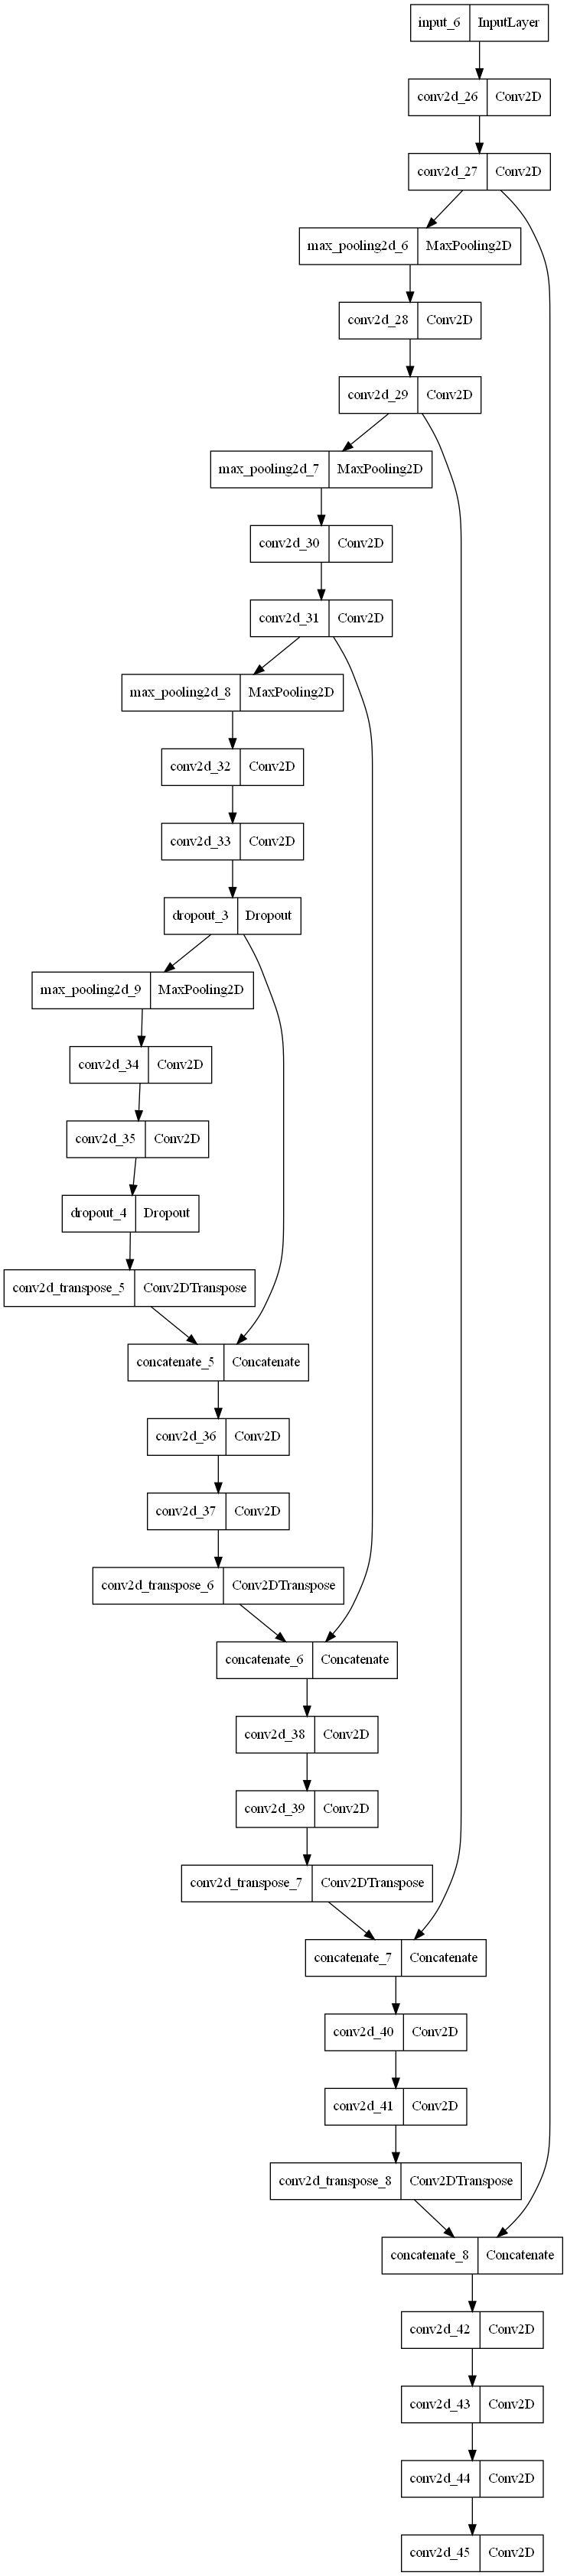

In [16]:
keras.utils.plot_model(u_net)

In [17]:
u_net.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [25]:
#dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(32)
autotune_ = tf.data.experimental.AUTOTUNE
dataset = dataset.prefetch(autotune_)
print(dataset.cardinality())

# EPOCHS = 40
# VAL_SUBSPLITS = 5
# BUFFER_SIZE = 500
# BATCH_SIZE = 32
# processed_image_ds.batch(BATCH_SIZE)
# train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# print(processed_image_ds.element_spec)
# model_history = unet.fit(train_dataset, epochs=EPOCHS)

tf.Tensor(32, shape=(), dtype=int64)


In [26]:
validation_set = dataset.take(6)
train_set = dataset.skip(6)
print(train_set.cardinality(),validation_set.cardinality())

tf.Tensor(26, shape=(), dtype=int64) tf.Tensor(6, shape=(), dtype=int64)


In [27]:
physical_device = tf.config.experimental.list_physical_devices("GPU")
print("NUm gpu available:" , len(physical_device))

NUm gpu available: 0


In [28]:
history = u_net.fit(train_set,epochs=2,validation_data=(validation_set))

Epoch 1/2


26/26 [==============================] - 83s 3s/step - loss: 3.1386 - accuracy: 0.2419 - val_loss: 2.5358 - val_accuracy: 0.3324
Epoch 2/2
26/26 [==============================] - 78s 3s/step - loss: 2.0544 - accuracy: 0.3352 - val_loss: 1.7399 - val_accuracy: 0.3454


beacuse training take a very long time so i trained the model with colab gpu and load that model here 

In [29]:
u_net.load_weights("u_net.h5")

In [30]:
u_net.evaluate(validation_set)

6/6 [==============================] - 6s 502ms/step - loss: 0.9972 - accuracy: 0.8094


[0.9971787333488464, 0.8094160556793213]

In [45]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

1/1 [==============================] - 0s 65ms/step


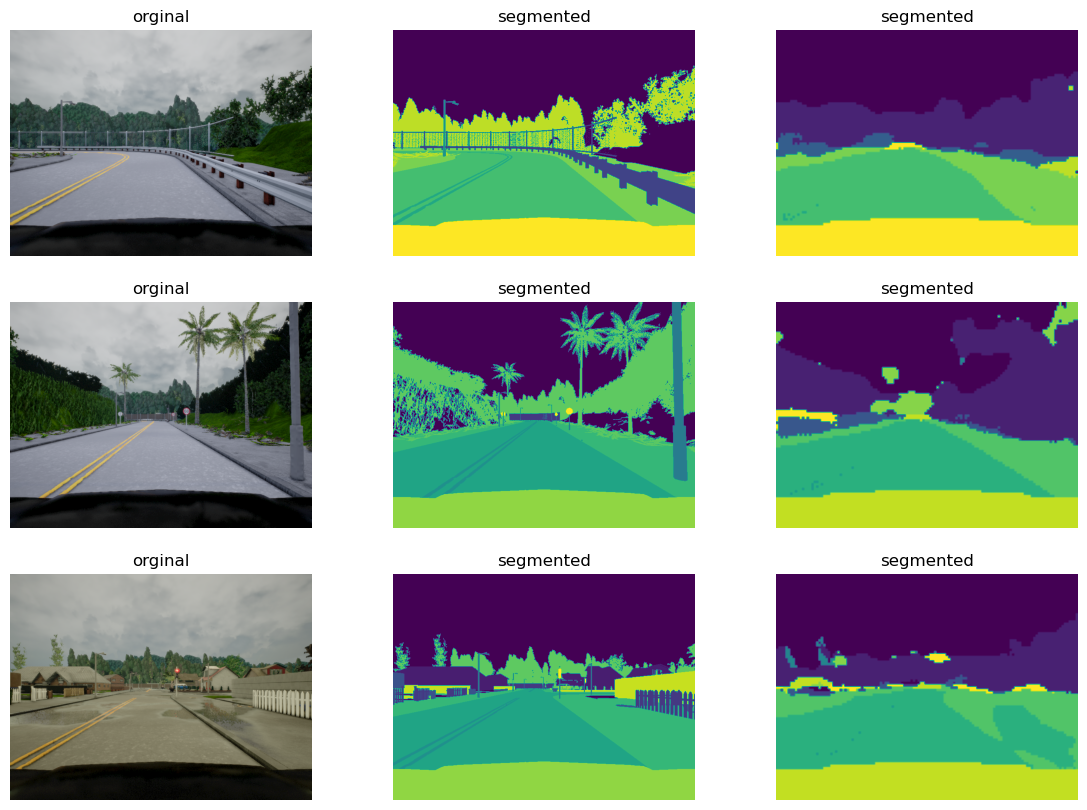

In [46]:
plt.figure(figsize=(14,10))
for i in range(1,9,3):
    n = np.random.randint(0,999)
    img = imageio.imread(images_path[n])
    #print(img.shape)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.axis("off")
    plt.title("orginal")
    
    plt.subplot(3,3,i+1)
    plt.imshow(imageio.imread(masks_path[n])[:,:,0])
    plt.axis("off")
    plt.title("segmented")
    pimg , _ = preprocess_path(images_path[n] , masks_path[n])
    #print(np.expand_dims(pimg,axis=0).shape)
    pred = u_net.predict(np.expand_dims(pimg,axis=0))
    #print(pred.shape)
    plt.subplot(3,3,i+2)
    plt.imshow(create_mask(pred))#np.argmax(pred[0],axis=-1))
    plt.axis("off")
    plt.title("segmented")